## Conservation of conformational and sequence features across homologs

This notebook reproduces Fig. 4

Authors: Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [1]:
import numpy as np
import pandas as pd
import glob 
import time
import random
from joblib import dump, load
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, gaussian_kde
from scipy.stats import binned_statistic, binned_statistic_2d
# function to calculate standard error of the mean
se = lambda x : np.std(x)/np.sqrt(x.size)
se.__name__ = 'SE'

In [2]:
# Load IDRome database
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
# Load randomly drawn indices for hold-out test set
inds10 = np.load('svr_model/inds10.npy')
# Scaling exponents in hold-out set
df_idrome_10 = df_idrome.iloc[inds10]
nu_10 = df_idrome_10[~df_idrome_10.fasta.duplicated()].nu
nu_10_svr = df_idrome_10[~df_idrome_10.fasta.duplicated()].nu_svr

#### Concatenate data for all the homologs collected by Lu et al. (DOI: 10.1371/journal.pcbi.1010238)
The sequences of orthologs of human IDRs were downloaded from https://zenodo.org/record/6311384/files/human_idr_homologues.zip

In [3]:
model = load('svr_model/svr_model.joblib') 
features_svr = ['scd','shd','kappa','fcr','mean_lambda']
dfs = []
for batch in range(0,15996,1000):
    df_i = pd.read_csv(f'conservation_analysis/data/nu_svm_{batch:d}.csv.gz',index_col=0,dtype='object')
    #df_i.rename({'FCR':'fcr'},axis=1,inplace=True)
    #for i in range(df_i.index.size):
    #    if not df_i.iloc[i][features_svr].isnull().values.any():
    #        df_i.iloc[i]['nu'] = float(model.predict(df_i.iloc[i][features_svr].values.reshape(1, -1)))
    #df_i.nu = df_i.nu.apply(lambda x: round(x,3))
    #df_i.to_csv(f'conservation_analysis/data/nu_svm_{batch:d}.csv.gz')
    dfs.append(df_i)
df = pd.concat(dfs).dropna()
print(df.shape)

(509156, 20)


#### Add columns with conformational and sequence feature of human IDRs

In [4]:
features = ['nu','mean_lambda','kappa','ncpr','scd','fcr','shd']

for feature in features:   
    df['human_'+feature] = df.HUMAN.apply(lambda x : df.loc[x,feature])
    
df['ID'] = df.index.map(lambda x: x.split('_')[0])

# Discard sequences for which a match was not found via API call to OMADB 
# (see conservation_analysis/code/analyse.py)
df = df.query('ID == omaid')
df.shape[0], df[df.index.str.startswith('HUMAN')].shape[0], df[~df.index.str.startswith('HUMAN')].shape[0]

(507059, 15140, 491919)

#### Calculate  standard deviations of Pearson correlation coefficients over 1,000 bootstraps

In [5]:
if not os.path.isfile('conservation_analysis/data/pearson_bootstrap.csv'):
    features = ['nu','mean_lambda','shd','scd','kappa']
    bootstrap = {}
    for feature in features:
        t0 = time.time()
        bootstrap[feature] = {}
        ortho = df[~df.index.str.startswith('HUMAN')][feature].astype(float)
        human = df[~df.index.str.startswith('HUMAN')]['human_'+feature].astype(float)
        indices = np.arange(human.size)
        bootstrap_pr = []
        for _ in range(1000):
            picked = random.choices(indices,k=indices.size)
            bootstrap_pr.append(pearsonr(human[picked],ortho[picked])[0])
        bootstrap[feature]['mean'] = np.mean(bootstrap_pr)
        bootstrap[feature]['std'] = np.std(bootstrap_pr)
        print('Time {:.3f}'.format(time.time()-t0))
    bootstrap = pd.DataFrame.from_dict(bootstrap)
    bootstrap.to_csv('conservation_analysis/data/pearson_bootstrap.csv') 
else:
    bootstrap = pd.read_csv('conservation_analysis/data/pearson_bootstrap.csv',index_col=0)

#### Fig. 4

0.8715889138733852 0.8720532900636059 0.014576199028289017
RMSE 0.019411288763624072 MAE 0.011656322989656322
0.816 0.002
0.8669 0.0006
0.9482 0.0002
0.6 0.1
0.692 0.002


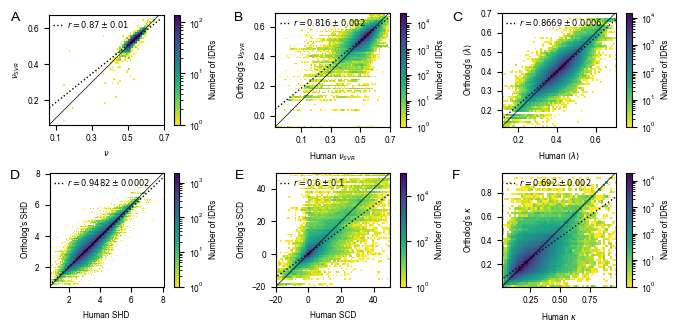

In [7]:
f, axes = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(6.6,3.3))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

interval = .01
bins = np.round(np.arange(nu_10.min(),nu_10.max(),interval),2)
h,_,_ = np.histogram2d(nu_10,nu_10_svr,bins=bins)
bins_center = bins[:-1] + interval/2
im = axes[0,0].imshow(h, cmap=plt.cm.viridis_r,extent=[bins_center.min(),bins_center.max(),
                                              bins_center.min(),bins_center.max()],
                 origin='lower',alpha=1,norm=LogNorm(vmin=1,vmax=h.max()),
                aspect='auto',interpolation='nearest')

axes[0,0].set_xlabel('$\\nu$')
axes[0,0].set_ylabel('$\\nu_{SVR}$')
x = np.linspace(nu_10.min(),nu_10.max(),100)
pr = pearsonr(nu_10,nu_10_svr)[0]

bootstrap_nu = []
indices = np.arange(nu_10.size)
for _ in range(1000):
    picked = random.choices(indices,k=indices.size)
    bootstrap_nu.append(pearsonr(nu_10[picked],nu_10_svr[picked])[0])
pr_mean = np.mean(bootstrap_nu)
pr_std = np.std(bootstrap_nu)
print(pr,pr_mean,pr_std)

rmse = np.sqrt(np.mean(np.power(nu_10-nu_10_svr,2)))
print('RMSE',rmse,'MAE',np.abs(nu_10-nu_10_svr).mean())
popt,_ = curve_fit(lambda x,a,b : a*x+b,nu_10,nu_10_svr)
axes[0,0].plot(x,popt[0]*x+popt[1],ls=':',lw=1,
               label='$r={:.2f} \pm {:.2f}$'.format(pr,pr_std),zorder=4,color='k')

axes[0,0].plot(x,x,lw=.5,zorder=4,color='k')

divider = make_axes_locatable(axes[0,0])
cax = divider.new_horizontal(size="{:.1f}%".format(5), pad=.1)
f.add_axes(cax)
cb = f.colorbar(im, cax=cax, orientation='vertical',
                label='Number of IDRs')

axes[0,0].set_aspect('equal')
axes[0,0].legend(frameon=False,handlelength=1.2,loc='upper left',borderpad=0,handletextpad=.4)

axes[0,0].set_xlim(bins_center.min(),bins_center.max())
axes[0,0].set_ylim(bins_center.min(),bins_center.max())
axes[0,0].set_xticks([.1,.3,.5,.7])

features = ['nu','mean_lambda','shd','scd','kappa']
labels = ['$\\nu_{SVR}$',r'$\langle \lambda \rangle$','SHD','SCD','$\\kappa$']
intervals = [.01,.01,.05,1,.02]
decimals = [2,2,2,0,2]

for i,feature,label,interval,decimal in zip(range(1,6),features,labels,intervals,decimals):
    
    ax = axes.flatten()[i]
    ortho = df[~df.index.str.startswith('HUMAN')][feature].astype(float)
    human = df[~df.index.str.startswith('HUMAN')]['human_'+feature].astype(float)
    bins = np.round(np.arange(human.min(),human.max(),interval),decimal)

    h,_,_ = np.histogram2d(human,ortho,bins=bins)
    bins_center = bins[:-1] + interval/2
    im = ax.imshow(h, cmap=plt.cm.viridis_r,extent=[bins_center.min(),bins_center.max(),
                                                  bins_center.min(),bins_center.max()],
                     origin='lower',alpha=1,norm=LogNorm(vmin=1,vmax=h.max()),
                    aspect='auto',interpolation='nearest')
    
    ax.set_xlabel('Human '+label)
    ax.set_ylabel("Ortholog's "+label)
    x = np.linspace(human.min(),human.max(),100)
    pr = pearsonr(human,ortho)[0]
    
    popt,_ = curve_fit(lambda x,a,b : a*x+b,human,ortho)
    
    round_pr = abs(int(np.log10(bootstrap[feature]['std'])))+1
    
    print(round(pr,round_pr),round(bootstrap[feature]['std'],round_pr))
    
    ax.plot(x,popt[0]*x+popt[1],ls=':',lw=1,label='$r={:g} \pm {:g}$'.format(
                round(pr,round_pr),round(bootstrap[feature]['std'],round_pr)),zorder=4,color='k')
    ax.plot(x,x,lw=.5,zorder=4,color='k')
    
    ax.set_xlim(bins_center.min(),bins_center.max())
    ax.set_ylim(bins_center.min(),bins_center.max())
    
    if label == 'SCD':
        ax.set_xlim(-20,50)
        ax.set_ylim(-20,50)
        
        
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size="{:.1f}%".format(5), pad=.1)
    f.add_axes(cax)
    cb = f.colorbar(im, cax=cax, orientation='vertical',
                label='Number of IDRs')
    
    ax.set_aspect('equal')
    ax.legend(frameon=False,handlelength=1.2,loc='upper left',borderpad=0,handletextpad=.4)
    
axes[0,1].set_xticks([.1,.3,.5,.7])
    
f.text(0, .94, 'A', fontsize=10)
f.text(0.34, .94, 'B', fontsize=10)
f.text(0.67, .94, 'C', fontsize=10)

f.text(0, .46, 'D', fontsize=10)
f.text(0.34, .46, 'E', fontsize=10)
f.text(0.67, .46, 'F', fontsize=10)
    
plt.tight_layout(w_pad=4)
plt.savefig('figs/fig4.png',dpi=300)
plt.show()